<div style="background-color:#2563eb; padding:12px; border-radius:8px;">
    <h2 style="color:white; margin:0; text-align:center; letter-spacing:1px;">
        OVERVIEW
    </h2>
</div>
This project uses the Recruit Restaurant Visitor Forecasting dataset, which contains historical restaurant visit information from Japan. The dataset combines restaurant details, daily visitor counts, reservation records, and calendar data. It is designed to predict the number of customers visiting each restaurant on a given date using time-series, location, and reservation-based features.

# Curriculum

1.  Setup Environment
2.  Load Dataset
3.  Understand the Data
4.  Data Prerocessing for EDA
5.  EDA
6.  Feature Engineering
7.  EDA part 2
8.  Statistical Significance Test
9.  Feature Encoding
10. Data Preprocessing for Model Building
11. Evaluation Metrics - Regression
12. Time Series Forecasting - ARIMA
13. Time Series Forecasting - Prophet
14. XGBoost Regression
15. XGBoost
16. CatBoost
17. LightGBM
18. Improve the Model - Hyperparameter Tuning
19. Ensemble (stacking)
20. Final RMSLE score and the recommendations

<div style="background-color:#2563eb; padding:12px; border-radius:8px;">
    <h2 style="color:white; margin:0; text-align:center; letter-spacing:1px;">
        Dataset
    </h2>
</div>

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
air_reserve_df = pd.read_csv(r"Data/air_reserve.csv")
air_store_df = pd.read_csv(r"Data/air_store_info.csv")
air_visit_data_df = pd.read_csv(r"Data/air_visit_data.csv")
hpg_reserve_df = pd.read_csv(r"Data/hpg_reserve.csv")
date_info_df = pd.read_csv(r"Data/date_info.csv")
hpg_store_info_df = pd.read_csv(r"Data/hpg_store_info.csv")
sample_submission_df = pd.read_csv(r"Data/sample_submission.csv")
store_id_relation_df = pd.read_csv(r"Data/store_id_relation.csv")

<h2>Airstore Reserve info</h2>

In [3]:
air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


Contains reservation-level records

Used to create daily aggregated features

Enhances forecasting accuracy significantly

Critical feature source for LightGBM models

<h2>Airstore info</h2>

In [4]:
air_store_df.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


Contains static restaurant metadata

One row per restaurant

Used for feature enrichment

Plays a key role in improving visitor forecasting accuracy

<h2>Air visit data info</h2>

In [5]:
air_visit_data_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


It is the core training dataset

Used to learn:

Daily demand patterns

Weekly seasonality

Weekend vs weekday trends

Restaurant popularity over time

<h2>hpg Reserve Info</h2>

In [6]:
hpg_reserve_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


Reservation data acts as a leading indicator of demand and helps the model identify:

High-traffic days

Weekend surges

Festival and holiday spikes

Advance booking behavior

<h2>date Info</h2>

In [7]:
date_info_df.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


This dataset tells the model what day it is and whether it is a holiday, which strongly affects how many customers visit restaurants.

<h2>hpg store info</h2>

In [8]:
hpg_store_info_df.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


pg_store_info.csv contains restaurant metadata from the Hot Pepper Gourmet platform, including cuisine type, location, and geographic coordinates.

<h2>sample submission </h2>

In [9]:
sample_submission_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


<h2>store id relation </h2>

In [10]:
store_id_relation_df.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


<div style="background-color:#2563eb; padding:12px; border-radius:8px;">
    <h2 style="color:white; margin:0; text-align:center; letter-spacing:1px;">
        UNDERSTANDING THE DATA
    </h2>
</div>

In [11]:

def about_data(df,data_description):
    print(f"First five rows about the dataset are :")
    print(df.head())
    print(f"Description about the dataset is : ")
    print(df.describe())
   
    for col in df.columns:
      data_description.loc[col,"Number_of_uniqueVlues"] = df[col].nunique()
      data_description.loc[col,"Size"] = len(df[col])
      data_description.loc[col,"Null_count"] = df[col].isnull().sum()
      data_description.loc[col,"Null_percentage"] = np.where(data_description.loc[col,"Null_count"]>=0,data_description.loc[col,"Null_count"]/len(df),0)
      data_description.loc[col,"most_frequent_value"] = df[col].value_counts().index[0]
      data_description.loc[col,"most_frequent_value_perc"] = df[col].value_counts(normalize=True).tolist()[1]
    return data_description

<h2>Airstore info understanding</h2>

In [12]:
summary_Airstore_info = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(air_store_df,summary_Airstore_info)

First five rows about the dataset are :
           air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    latitude   longitude  
0  34.695124  135.197853  
1  34.695124  135.197853  
2  34.695124  135.197853  
3  34.695124  135.197853  
4  35.658068  139.751599  
Description about the dataset is : 
         latitude   longitude
count  829.000000  829.000000
mean    35.647042  137.415311
std      2.084659    3.650971
min     33.211967  130.195555
25%     34.695124  135.341564
50%     35.658068  139.685474
75%     35.694003  139.751599
max     44.020632  144.273398


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
air_store_id,829,829,0,0.0,air_c8fe396d6c46275d,0.001206
air_genre_name,14,829,0,0.0,Izakaya,0.218335
air_area_name,103,829,0,0.0,Fukuoka-ken Fukuoka-shi Daimyō,0.069964
latitude,108,829,0,0.0,33.589216,0.069964
longitude,108,829,0,0.0,130.392813,0.069964


<h2>hpg store info summary</h2>

In [13]:
summary_hpgstore_info = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(hpg_store_info_df,summary_hpgstore_info)

First five rows about the dataset are :
           hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221  
3  35.643675  139.668221  
4  35.643675  139.668221  
Description about the dataset is : 
          latitude    longitude
count  4690.000000  4690.000000
mean     35.810261   137.675816
std       2.138755     3.197233
min      33.311645   130.339313
25%      34.692109   135.498859
50%      35.659214   139.495733
75%      35.703381   139.737998
max      43.774846   143.714585


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
hpg_store_id,4690,4690,0,0.0,hpg_11801306ce8bfb4f,0.000213
hpg_genre_name,34,4690,0,0.0,Japanese style,0.149254
hpg_area_name,119,4690,0,0.0,Tōkyō-to Shinjuku-ku None,0.042217
latitude,129,4690,0,0.0,35.691384,0.042217
longitude,129,4690,0,0.0,139.701256,0.042217


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

__inferences from Air Store Dataset__

Dataset Size & Structure

Contains 829 unique stores (air_store_id = 829 unique).

No duplicate store IDs → each row represents one store.

Missing Values

No null values in any column (Null_percentage = 0% for all).

Dataset is clean and ready for modeling.

Categorical Features

air_genre_name has 14 unique categories.

Most frequent genre: Izakaya (~21.8%), indicating popularity of casual Japanese dining.

air_area_name has 103 unique areas, showing good geographic diversity.

Geographical Distribution

Latitude range: 33.21 → 44.02

Longitude range: 130.19 → 144.27

Indicates stores spread across Japan, from southern to northern regions.

Location Concentration

Same latitude & longitude repeating suggests multiple stores located in the same area/building.

Median location (~35.65, 139.68) points toward urban centers (Tokyo-Osaka belt).

Data Balance Insight

Most frequent area contributes only ~7%, so no heavy geographic bias.

__Inferences from HPG Store Dataset__

Dataset Size & Granularity

Contains 4,690 unique stores, much larger than Air dataset.

Each hpg_store_id is unique → high coverage.

Missing Values

Zero null values across all columns.

No preprocessing needed for missing data.

Categorical Features

hpg_genre_name has 34 unique categories → more granular cuisine classification.

Most frequent genre: Japanese style (~14.9%).

Area Information

hpg_area_name has 119 unique locations.

Most frequent area contributes only ~4.2%, showing strong spatial diversity.

Geographical Spread

Latitude range: 33.31 → 43.77

Longitude range: 130.33 → 143.71

Covers almost the same national span as Air dataset.

Urban Density Indicator

Repeated latitude/longitude values indicate store clustering in busy districts (e.g., Setagaya, Shinjuku).

__Comparative Inferences (Air vs HPG)__

Scale Difference

HPG dataset (~4690 stores) is ~5.6× larger than Air dataset (829 stores).

Genre Granularity

HPG has more detailed genre classification (34 vs 14).

Air genres are more aggregated.

Geographic Consistency

Both datasets cover similar geographic ranges, enabling location-based merging or mapping.

Data Quality

Both datasets are clean, complete, and modeling-ready.

EDA Implication

Latitude & longitude are strong candidates for:

Spatial clustering

Distance-based features

Regional demand analysis


<h2>Air visit data info understanding</h2>

In [14]:
summary_visit_info = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(air_visit_data_df,summary_visit_info)

First five rows about the dataset are :
           air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6
Description about the dataset is : 
            visitors
count  252108.000000
mean       20.973761
std        16.757007
min         1.000000
25%         9.000000
50%        17.000000
75%        29.000000
max       877.000000


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
air_store_id,829,252108,0,0.0,air_5c817ef28f236bdf,0.001888
visit_date,478,252108,0,0.0,2017-03-17,0.003138
visitors,204,252108,0,0.0,8,0.034446


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>


__Inferences from Air Visit Dataset__

Dataset Size & Structure

Contains 252,108 records of daily store visits.

Covers 829 unique stores, matching the Air Store metadata → relational consistency.

Time Dimension

visit_date has 478 unique dates, indicating ~1.3 years of daily data.

Suitable for time-series forecasting and trend analysis.

Target Variable (Visitors)

Mean visitors per store per day ≈ 21.

Median visitors = 17, which is lower than the mean → right-skewed distribution.

Visitor Variability

Standard deviation (16.76) is close to the mean → high variability in daily visits.

Indicates demand is unstable and event-driven.

Outliers Present

Maximum visitors = 877, which is extremely high compared to Q3 (29).

Suggests special events, holidays, promotions, or data outliers.

Lower Bound Insight

Minimum visitors = 1, meaning stores can have very low footfall on some days.

Important for loss functions sensitive to zero/low counts.

Missing Values

No missing values in any column (0% nulls).

Dataset is clean and directly usable.

Store Representation Balance

Most frequent air_store_id appears only 0.19% of the time.

Indicates no store dominates the dataset.

Date Distribution Balance

Most frequent date contributes ~0.31%, showing uniform temporal coverage.

Visitor Frequency Pattern

Most common visitor count is 8 (~3.4%).

Confirms low-to-moderate daily demand is typical.


<h2>Reservation data summary</h2>

In [15]:
summary_air_reserve = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(air_reserve_df,summary_air_reserve)

First five rows about the dataset are :
           air_store_id       visit_datetime     reserve_datetime  \
0  air_877f79706adbfb06  2016-01-01 19:00:00  2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
3  air_877f79706adbfb06  2016-01-01 20:00:00  2016-01-01 16:00:00   
4  air_db80363d35f10926  2016-01-01 20:00:00  2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5  
Description about the dataset is : 
       reserve_visitors
count      92378.000000
mean           4.481749
std            4.919669
min            1.000000
25%            2.000000
50%            3.000000
75%            5.000000
max          100.000000


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
air_store_id,314,92378,0,0.0,air_8093d0b565e9dbdf,0.0206
visit_datetime,4975,92378,0,0.0,2016-12-24 19:00:00,0.00249
reserve_datetime,7513,92378,0,0.0,2016-11-24 18:00:00,0.001115
reserve_visitors,71,92378,0,0.0,2,0.164531


__checking starting date for reserve and reserve_visitors datetime__

In [16]:
starting_date_reserve = air_reserve_df["reserve_datetime"].min()
ending_date_reserve  = air_reserve_df["reserve_datetime"].max()

In [17]:
print(f"starting date samples were taken : {starting_date_reserve}")
print(f"Ending date samples were taken : {ending_date_reserve}")

starting date samples were taken : 2016-01-01 01:00:00
Ending date samples were taken : 2017-04-22 23:00:00


In [18]:
span_res = pd.to_datetime(ending_date_reserve)-pd.to_datetime(starting_date_reserve)

In [19]:
span_res.days

477

In [20]:
starting_date_vi= air_reserve_df["visit_datetime"].min()
ending_date_vi  = air_reserve_df["visit_datetime"].max()

print(f"starting date samples were taken : {starting_date_vi}")
print(f"Ending date samples were taken : {ending_date_vi}")

In [21]:
span_res = pd.to_datetime(ending_date_vi)-pd.to_datetime(starting_date_vi)

In [22]:
span_res.days

516

__stores present air reserve data not present in air info data__

In [23]:
stores_not_inAirReseve = set(air_store_df["air_store_id"].unique())-set(air_reserve_df["air_store_id"].unique())

In [24]:
len(stores_not_inAirReseve)

515

<h2>hpg Reserve Data summary</h2>

In [25]:
summary_hpg_reserve = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(hpg_reserve_df,summary_hpg_reserve)

First five rows about the dataset are :
           hpg_store_id       visit_datetime     reserve_datetime  \
0  hpg_c63f6f42e088e50f  2016-01-01 11:00:00  2016-01-01 09:00:00   
1  hpg_dac72789163a3f47  2016-01-01 13:00:00  2016-01-01 06:00:00   
2  hpg_c8e24dcf51ca1eb5  2016-01-01 16:00:00  2016-01-01 14:00:00   
3  hpg_24bb207e5fd49d4a  2016-01-01 17:00:00  2016-01-01 11:00:00   
4  hpg_25291c542ebb3bc2  2016-01-01 17:00:00  2016-01-01 03:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 2  
3                 5  
4                13  
Description about the dataset is : 
       reserve_visitors
count      2.000320e+06
mean       5.073785e+00
std        5.416172e+00
min        1.000000e+00
25%        2.000000e+00
50%        3.000000e+00
75%        6.000000e+00
max        1.000000e+02


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
hpg_store_id,13325,2000320,0,0.0,hpg_2afd5b187409eeb4,0.000411
visit_datetime,9847,2000320,0,0.0,2016-12-16 19:00:00,0.005237
reserve_datetime,11450,2000320,0,0.0,2016-12-12 21:00:00,0.000444
reserve_visitors,99,2000320,0,0.0,2,0.157853


In [26]:
hpg_starting_date_vi= hpg_reserve_df["visit_datetime"].min()
hpg_ending_date_vi  = hpg_reserve_df["visit_datetime"].max()

In [27]:
print(f"starting date samples were taken : {hpg_starting_date_vi}")
print(f"Ending date samples were taken : {hpg_ending_date_vi}")

starting date samples were taken : 2016-01-01 11:00:00
Ending date samples were taken : 2017-05-31 23:00:00


In [28]:
(pd.to_datetime(ending_date_vi)-pd.to_datetime(starting_date_vi)).days

516

In [29]:
stores_not_inhpgReseve = set(hpg_store_info_df["hpg_store_id"].unique())-set(hpg_reserve_df["hpg_store_id"].unique())

In [30]:
len(stores_not_inhpgReseve)

0

In [31]:
stores_not_inhpginfo = set(hpg_reserve_df["hpg_store_id"].unique())-set(hpg_store_info_df["hpg_store_id"].unique())

In [32]:
len(stores_not_inhpginfo)

8635

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

The Air dataset contains 314 unique stores, identified by distinct air_store_id values.

The HPG dataset includes 13,325 unique stores, indicating a much larger coverage compared to Air.

No missing values are present across any of the datasets, confirming good data quality.

Both datasets share a common structure with five columns: store ID, genre name, area name, latitude, and longitude.

Every store listed in the Air reservation dataset has corresponding store information available in the Air store information dataset, ensuring complete mapping.

In contrast, the HPG reservation dataset includes a significant number of stores that are absent from the HPG store information dataset; specifically, 8,635 stores in the reservation data lack associated store metadata.

<h2> Date info summary</h2>

In [33]:
summary_date_info_df = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(date_info_df,summary_date_info_df)

First five rows about the dataset are :
  calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0
Description about the dataset is : 
       holiday_flg
count   517.000000
mean      0.067698
std       0.251471
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
calendar_date,517,517,0,0.0,2017-05-31,0.001934
day_of_week,7,517,0,0.0,Friday,0.143133
holiday_flg,2,517,0,0.0,0,0.067698


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Dataset Size & Coverage

The dataset contains 517 records, each representing a unique calendar date.

calendar_date has 517 unique values, confirming a one-row-per-date structure.

Temporal Scope

Covers dates from early 2016 to mid-2017, aligning well with the visit and reservation datasets.

Suitable for time-based feature enrichment.

Missing Values

No missing values are present in any column (0% nulls).

Dataset is clean and reliable for direct merging.

Day-of-Week Information

day_of_week has 7 unique values, representing all days from Monday to Sunday.

The most frequent day is Friday (~14.3%), indicating an almost uniform weekly distribution.

Holiday Flag Distribution

holiday_flg is a binary feature with values {0, 1}.

Only ~6.8% of dates are holidays, showing strong class imbalance.

Holiday Statistics

Mean holiday flag value (~0.068) confirms that most dates are non-holidays.

Median and 75th percentile are both 0, reinforcing the sparsity of holidays.

Data Type Insight

holiday_flg is numeric but categorical in nature, making it suitable for:

Classification-style interpretation

Binary feature usage in ML models

Most Frequent Values

Most frequent date appears only ~0.19%, confirming no temporal bias.

Most frequent holiday flag value is 0 (non-holiday), as expected.

<h2>Store Id Relations</h2>

In [34]:
summary_store_id_relation_df = pd.DataFrame(columns=["Number_of_uniqueVlues","Size","Null_count","Null_percentage","most_frequent_value","most_frequent_value_perc"])
about_data(store_id_relation_df,summary_store_id_relation_df)

First five rows about the dataset are :
           air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7
Description about the dataset is : 
                air_store_id          hpg_store_id
count                    150                   150
unique                   150                   150
top     air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
freq                       1                     1


,Number_of_uniqueVlues,Size,Null_count,Null_percentage,most_frequent_value,most_frequent_value_perc
air_store_id,150,150,0,0.0,air_63b13c56b7201bd9,0.006667
hpg_store_id,150,150,0,0.0,hpg_4bc649e72e2a239a,0.006667


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Dataset Purpose

This dataset provides a mapping between Air store IDs and HPG store IDs, enabling cross-platform integration.

Dataset Size Contains 150 records, each representing one mapped store pair.

One-to-One Relationship

Both air_store_id and hpg_store_id have 150 unique values.

Each Air store maps to exactly one HPG store and vice versa.

No Missing Values

Zero null values in both columns.

Dataset is clean and reliable for joining operations.

No Duplicate Mappings

Frequency of the most common ID is 1, confirming:

No duplicate Air IDs

No duplicate HPG IDs

No many-to-one or one-to-many relationships

Balanced Mapping

Both columns have identical size and uniqueness counts, indicating a perfectly balanced mapping table.

Coverage Limitation

Only 150 Air stores have a corresponding HPG store mapping.

The majority of stores in Air and HPG datasets remain unmapped.

<h2>Submission Data summary</h2>

In [35]:
sample_submission_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [36]:
submission_df = sample_submission_df.copy()

In [37]:
submission_df["visit_datetime"] = sample_submission_df["id"].apply(lambda x : x.split("_")[-1])
submission_df["store_type"]     = sample_submission_df["id"].apply(lambda x : x.split("_")[0])
submission_df["store_id"]       = sample_submission_df["id"].apply(lambda x : re.sub(r'_\d{4}-\d{2}-\d{2}',"",x))

In [38]:
submission_df

,id,visitors,visit_datetime,store_type,store_id
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air,air_00a91d42b08b08d9
...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27,air,air_fff68b929994bfbd
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28,air,air_fff68b929994bfbd
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air,air_fff68b929994bfbd
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air,air_fff68b929994bfbd


In [39]:
submission_df["visit_datetime"].dtype

dtype('O')

In [40]:
submission_df["visit_datetime"]=pd.to_datetime(submission_df.loc[:,"visit_datetime"],format='%Y-%m-%d')

In [41]:
submission_df.describe()

,visitors,visit_datetime
count,32019.0,32019
mean,0.0,2017-05-12 00:00:00
min,0.0,2017-04-23 00:00:00
25%,0.0,2017-05-02 00:00:00
50%,0.0,2017-05-12 00:00:00
75%,0.0,2017-05-22 00:00:00
max,0.0,2017-05-31 00:00:00
std,0.0,NaN


In [42]:
starting_date = submission_df["visit_datetime"].min()
ending_Date   = submission_df["visit_datetime"].max()

In [43]:
print(f"starting date : {starting_date}")
print(f"ending date : {ending_Date}")

starting date : 2017-04-23 00:00:00
ending date : 2017-05-31 00:00:00


In [44]:
ending_Date-starting_date

Timedelta('38 days 00:00:00')

__store preent in submission data but not in air reserve data__

In [45]:
store_in_air=set(air_reserve_df["air_store_id"])-set(submission_df["store_id"])

In [46]:
len(store_in_air)

0

In [47]:
store_in_air=set(hpg_reserve_df["hpg_store_id"])-set(submission_df["store_id"])

In [48]:
len(store_in_air)

13325

<div style="background-color:#2563eb; padding:12px; border-radius:8px;">
    <h2 style="color:white; margin:0; text-align:center; letter-spacing:1px;">
       DATA PREPROCESSING
    </h2>
</div>
MERGING ALL DATA TO CREATE SINGLE DATASET

<H2>Prepare store info</H2>

In [49]:
store_id_relation_df.head(1)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a


In [50]:
store_id_relation_df.shape

(150, 2)

In [51]:
air_store_df.head(1)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853


In [52]:
air_store_df.shape

(829, 5)

In [53]:
# merging with air_store_df with store_id_relation
stores_df=pd.merge(left=air_store_df,right=store_id_relation_df,on='air_store_id',how='left')
stores_df.head(1)

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN


In [54]:
stores_df.shape

(829, 6)

In [55]:
stores_df = pd.merge(left=stores_df,right=hpg_store_info_df,how='left',on='hpg_store_id')

In [56]:
stores_df.head(1)

,air_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN


In [57]:
stores_df.shape

(829, 10)

In [58]:
# miss= set(store_id_relation_df["air_store_id"])-set(air_store_df["air_store_id"])
# len(miss)

In [59]:
# miss= set(store_id_relation_df["hpg_store_id"])-set(hpg_store_info_df["hpg_store_id"])
# len(miss)

In [60]:
print(f"hpg_area_name empty rows percentage{stores_df['hpg_area_name'].isnull().sum()/len(stores_df)}")
print(f"air_area_name empty rows percentage{stores_df['air_area_name'].isnull().sum()/len(stores_df)}")

hpg_area_name empty rows percentage0.9240048250904704
air_area_name empty rows percentage0.0


<h2>Merging Reserve data</h2>

In [61]:
store_id_relation_df.head(1)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a


In [62]:
air_reserve_df.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


In [63]:
air_reserve_df.shape

(92378, 4)

In [64]:
hpg_reserve_df.head(1)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1


In [65]:
hpg_reserve_df.shape

(2000320, 4)

In [66]:
hpg_store_reserve=pd.merge(left=hpg_reserve_df,right=store_id_relation_df,on='hpg_store_id')[air_reserve_df.columns]

In [67]:
store_reserve=pd.concat([air_reserve_df,hpg_store_reserve],axis=0)

In [68]:
store_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


<h2>Air visit data preprocessing</h2>

In [69]:
air_visit_data_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [70]:
submission_df.head()

,id,visitors,visit_datetime,store_type,store_id
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air,air_00a91d42b08b08d9


In [71]:
air_visit_data_df.loc[:,"id"] =air_visit_data_df.apply(lambda x : f"{x['air_store_id']}_{x['visit_date']}",axis=1)
air_visit_data_df.loc[:,"store_type"] =air_visit_data_df['air_store_id'].apply(lambda x : x.split("_")[0])

In [72]:
air_visit_data_df.head()

,air_store_id,visit_date,visitors,id,store_type
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,air
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,air
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,air
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,air
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,air


In [73]:
air_visit_df = air_visit_data_df.loc[:,["id","visitors","visit_date","store_type","air_store_id"]].copy()
air_visit_df.columns = ["id","visitors","visit_datetime","store_type","store_id"]

In [74]:
air_visit_df.head()

,id,visitors,visit_datetime,store_type,store_id
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2016-01-14,32,2016-01-14,air,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2016-01-15,29,2016-01-15,air,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2016-01-16,22,2016-01-16,air,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2016-01-18,6,2016-01-18,air,air_ba937bf13d40fb24


In [75]:
air_visit_df.shape

(252108, 5)

In [76]:
air_visitor_data=air_visit_df.loc[(air_visit_df["store_id"].isin(submission_df["store_id"])),:]

In [77]:
air_visitor_data

,id,visitors,visit_datetime,store_type,store_id
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2016-01-14,32,2016-01-14,air,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2016-01-15,29,2016-01-15,air,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2016-01-16,22,2016-01-16,air,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2016-01-18,6,2016-01-18,air,air_ba937bf13d40fb24
...,...,...,...,...,...
252103,air_24e8414b9b07decb_2017-04-18,6,2017-04-18,air,air_24e8414b9b07decb
252104,air_24e8414b9b07decb_2017-04-19,6,2017-04-19,air,air_24e8414b9b07decb
252105,air_24e8414b9b07decb_2017-04-20,7,2017-04-20,air,air_24e8414b9b07decb
252106,air_24e8414b9b07decb_2017-04-21,8,2017-04-21,air,air_24e8414b9b07decb


__concatinating airvisitor data(data which contain common id in submission and air visitor) with submission data, and creating a column named dataset which having the variable past and present__

In [78]:
air_visit_cl = pd.concat([air_visitor_data,submission_df],axis=0)

air_visit_cl .head()

,id,visitors,visit_datetime,store_type,store_id
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2016-01-14,32,2016-01-14,air,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2016-01-15,29,2016-01-15,air,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2016-01-16,22,2016-01-16,air,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2016-01-18,6,2016-01-18,air,air_ba937bf13d40fb24


In [79]:
air_visit_cl.columns

Index(['id', 'visitors', 'visit_datetime', 'store_type', 'store_id'], dtype='object')

In [80]:
# air_visit_cl["dataset"]=air_visit_cl.apply(lambda x:"past" if x["id"] in set(air_visitor_data["id"]) else "future",axis=1)

In [81]:
air_visit_cl["dataset"]=np.where(air_visit_cl["id"].isin(submission_df["id"]),"future","past")

In [82]:
air_visit_cl['visit_datetime']=pd.to_datetime(air_visit_cl['visit_datetime'],format="%Y-%m-%d")

In [83]:
air_visit_cl .head()

,id,visitors,visit_datetime,store_type,store_id,dataset
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24,past
1,air_ba937bf13d40fb24_2016-01-14,32,2016-01-14,air,air_ba937bf13d40fb24,past
2,air_ba937bf13d40fb24_2016-01-15,29,2016-01-15,air,air_ba937bf13d40fb24,past
3,air_ba937bf13d40fb24_2016-01-16,22,2016-01-16,air,air_ba937bf13d40fb24,past
4,air_ba937bf13d40fb24_2016-01-18,6,2016-01-18,air,air_ba937bf13d40fb24,past


In [84]:
date_info_df.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [85]:
date_info_df["visit_datetime"]=date_info_df.calendar_date.rename("visit_datetime",inplace=True)

In [86]:
date_info_df["visit_datetime"] = pd.to_datetime(date_info_df["visit_datetime"], format="%Y-%m-%d")

In [87]:
date_info_df.head(15)

,calendar_date,day_of_week,holiday_flg,visit_datetime
0,2016-01-01,Friday,1,2016-01-01
1,2016-01-02,Saturday,1,2016-01-02
2,2016-01-03,Sunday,1,2016-01-03
3,2016-01-04,Monday,0,2016-01-04
4,2016-01-05,Tuesday,0,2016-01-05
5,2016-01-06,Wednesday,0,2016-01-06
6,2016-01-07,Thursday,0,2016-01-07
7,2016-01-08,Friday,0,2016-01-08
8,2016-01-09,Saturday,0,2016-01-09
9,2016-01-10,Sunday,0,2016-01-10


In [88]:
date_info_df.drop(columns=["calendar_date"],inplace=True)

In [89]:
date_info_df.head()

,day_of_week,holiday_flg,visit_datetime
0,Friday,1,2016-01-01
1,Saturday,1,2016-01-02
2,Sunday,1,2016-01-03
3,Monday,0,2016-01-04
4,Tuesday,0,2016-01-05


In [90]:
date_info_df["weekend_holiday"] = date_info_df.apply(lambda x: 1 if x['day_of_week']=='Saturday' or x['day_of_week']=='Sunday' else 0,axis=1)

In [91]:
date_info_df.head()

,day_of_week,holiday_flg,visit_datetime,weekend_holiday
0,Friday,1,2016-01-01,0
1,Saturday,1,2016-01-02,1
2,Sunday,1,2016-01-03,1
3,Monday,0,2016-01-04,0
4,Tuesday,0,2016-01-05,0


In [92]:
date_info_df["work_off"] = date_info_df.apply(lambda x: 1 if x['holiday_flg']==1 or x['weekend_holiday']==1 else 0,axis=1)

In [93]:
date_info_df.head()

,day_of_week,holiday_flg,visit_datetime,weekend_holiday,work_off
0,Friday,1,2016-01-01,0,1
1,Saturday,1,2016-01-02,1,1
2,Sunday,1,2016-01-03,1,1
3,Monday,0,2016-01-04,0,0
4,Tuesday,0,2016-01-05,0,0


In [94]:
date_info_df["yesterday_isholiday"] = date_info_df.work_off.shift(1).fillna(0).astype(int)

In [95]:
date_info_df["tomarrow_isholiday"]   =  date_info_df.work_off.shift(-1).fillna(0).astype(int)

In [96]:
date_info_df.head()

,day_of_week,holiday_flg,visit_datetime,weekend_holiday,work_off,yesterday_isholiday,tomarrow_isholiday
0,Friday,1,2016-01-01,0,1,0,1
1,Saturday,1,2016-01-02,1,1,1,1
2,Sunday,1,2016-01-03,1,1,1,0
3,Monday,0,2016-01-04,0,0,1,0
4,Tuesday,0,2016-01-05,0,0,0,0


In [97]:
air_visit_cl=pd.merge(air_visit_cl,date_info_df,on='visit_datetime',how='inner')

In [98]:
air_visit_cl.head()

,id,visitors,visit_datetime,store_type,store_id,dataset,day_of_week,holiday_flg,weekend_holiday,work_off,yesterday_isholiday,tomarrow_isholiday
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24,past,Wednesday,0,0,0,0,0
1,air_ba937bf13d40fb24_2016-01-14,32,2016-01-14,air,air_ba937bf13d40fb24,past,Thursday,0,0,0,0,0
2,air_ba937bf13d40fb24_2016-01-15,29,2016-01-15,air,air_ba937bf13d40fb24,past,Friday,0,0,0,0,1
3,air_ba937bf13d40fb24_2016-01-16,22,2016-01-16,air,air_ba937bf13d40fb24,past,Saturday,0,1,1,0,1
4,air_ba937bf13d40fb24_2016-01-18,6,2016-01-18,air,air_ba937bf13d40fb24,past,Monday,0,0,0,1,0


In [99]:
air_visit_cl.shape

(282487, 12)

<div style="background-color:#2563eb; padding:12px; border-radius:8px;">
    <h2 style="color:white; margin:0; text-align:center; letter-spacing:1px;">
       Exploratory Data Analysis
    </h2>
</div>

underlying patterns, relationships, and trends. It helps determine whether any variables may be useful for predicting the target variable. Visualization techniques are commonly used to summarize the data and highlight key characteristics. Overall, EDA focuses on discovering what the data reveals beyond formal modeling or hypothesis-testing approaches.

The objectives of this section are to:

Gain insights from the visitor data

Examine the distribution of the target variable and determine whether transformation is required

Analyze reservation data and understand its relationship with store visits

Explore and extract insights from the store information data

Identify significant variables (addressed in the next section)

In [100]:
visits_df_past = air_visit_cl.loc[air_visit_cl["dataset"]=='past',:]

In [101]:
visits_df_past.head()

,id,visitors,visit_datetime,store_type,store_id,dataset,day_of_week,holiday_flg,weekend_holiday,work_off,yesterday_isholiday,tomarrow_isholiday
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24,past,Wednesday,0,0,0,0,0
1,air_ba937bf13d40fb24_2016-01-14,32,2016-01-14,air,air_ba937bf13d40fb24,past,Thursday,0,0,0,0,0
2,air_ba937bf13d40fb24_2016-01-15,29,2016-01-15,air,air_ba937bf13d40fb24,past,Friday,0,0,0,0,1
3,air_ba937bf13d40fb24_2016-01-16,22,2016-01-16,air,air_ba937bf13d40fb24,past,Saturday,0,1,1,0,1
4,air_ba937bf13d40fb24_2016-01-18,6,2016-01-18,air,air_ba937bf13d40fb24,past,Monday,0,0,0,1,0


In [102]:
pt1= visits_df_past.groupby("visit_datetime")["visitors"].agg(['sum','count'])

In [103]:
pt1=pt1.reset_index()

In [104]:
pt1.head()

,visit_datetime,sum,count
0,2016-01-01,955,46
1,2016-01-02,1727,62
2,2016-01-03,2334,80
3,2016-01-04,3326,157
4,2016-01-05,3916,230


In [105]:
import matplotlib.pyplot as plt

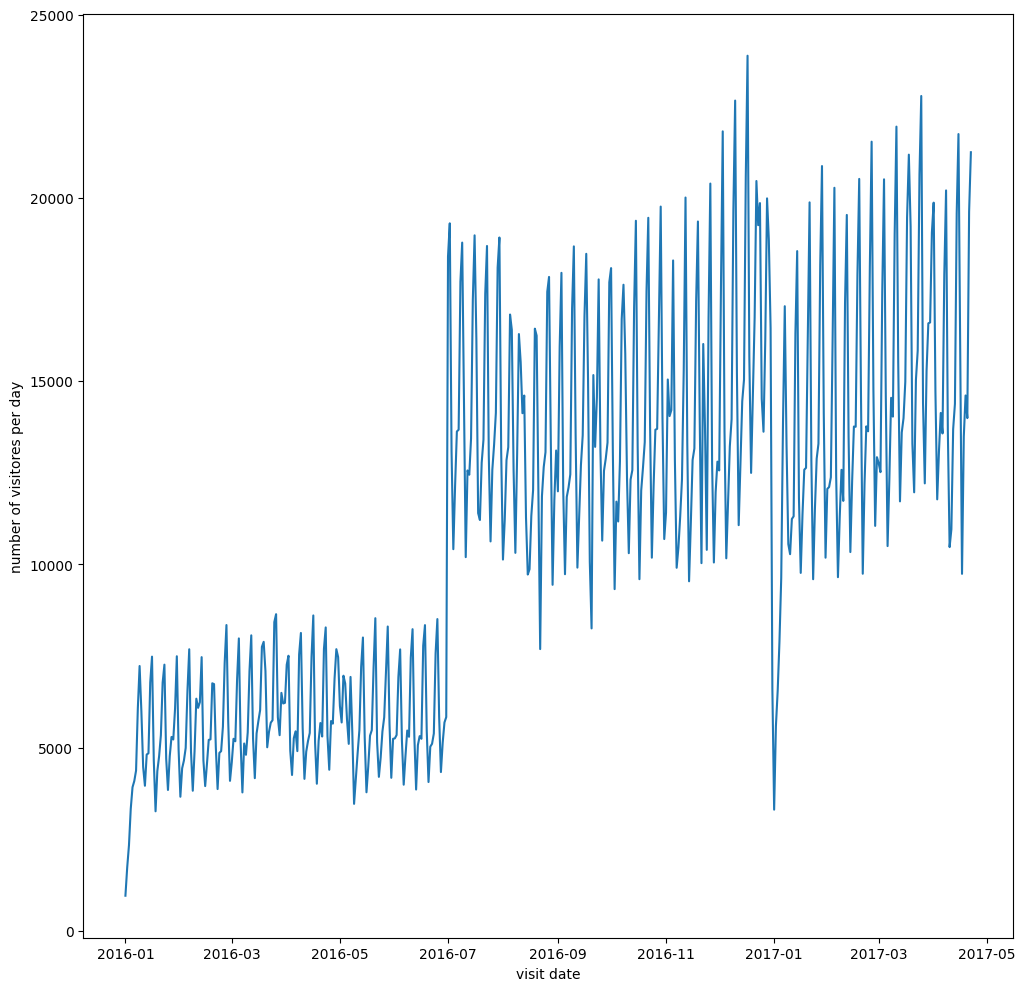

In [106]:
fig = plt.figure(figsize=(12,12))
plt.plot(pt1.loc[:,"visit_datetime"],pt1["sum"])
plt.xlabel("visit date")
plt.ylabel("number of visitores per day")
plt.savefig(r"image/date vs visitors")
plt.show()

In [107]:
pt2 = visits_df_past.groupby("visit_datetime")["store_id"].agg(['count','nunique'])

In [108]:
pt2

,count,nunique
visit_datetime,,
2016-01-01,46,46
2016-01-02,62,62
2016-01-03,80,80
2016-01-04,157,157
2016-01-05,230,230
...,...,...
2017-04-18,722,722
2017-04-19,734,734
2017-04-20,749,749


In [109]:
import seaborn as sns

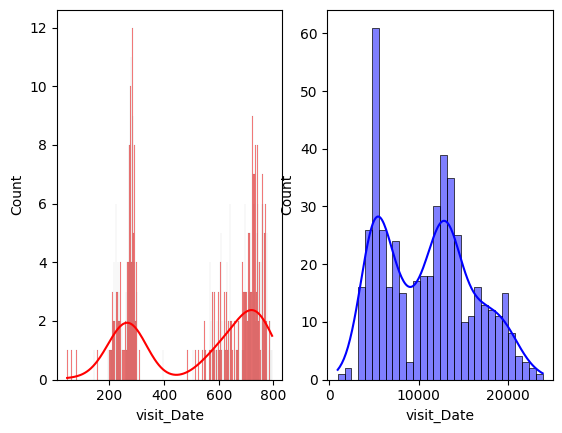

In [115]:
fig,ax = plt.subplots(1,2)
sns.histplot(data=pt2,x="count",color='red',bins=400,kde=True,ax=ax[0])
ax[0].set_xlabel("visit_Date")
sns.histplot(data=pt1,x="sum",color='blue',bins=30,kde=True,ax=ax[1])
ax[1].set_xlabel("visit_Date")
plt.savefig(r"image/frequency_plot")


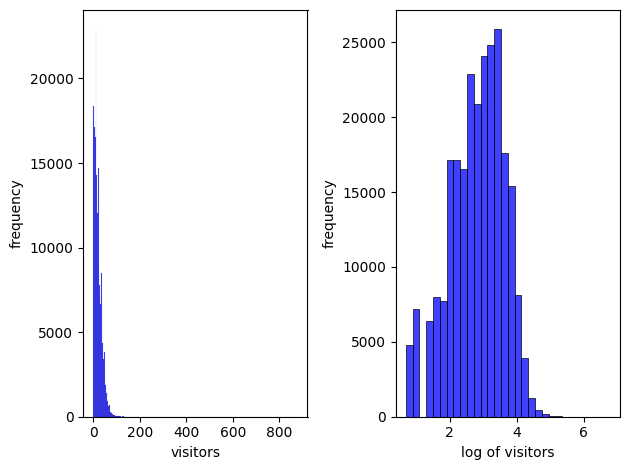

In [119]:
fig,ax = plt.subplots(1,2)
sns.histplot(data=visits_df_past["visitors"],color='blue',bins=400,ax=ax[0])
ax[0].set_xlabel("visitors")
ax[0].set_ylabel("frequency")
sns.histplot(data=np.log1p(visits_df_past["visitors"]),color='blue',bins=30,ax=ax[1])
ax[1].set_xlabel("log of visitors")
ax[1].set_ylabel("frequency")
plt.tight_layout()


<Axes: >

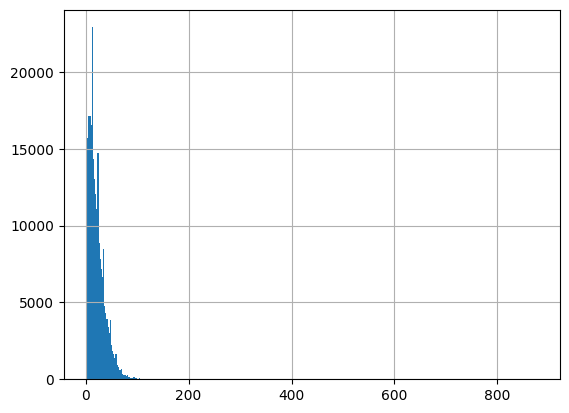

In [112]:
# visits_df_past["visitors"].hist(bins=400)

<Axes: >

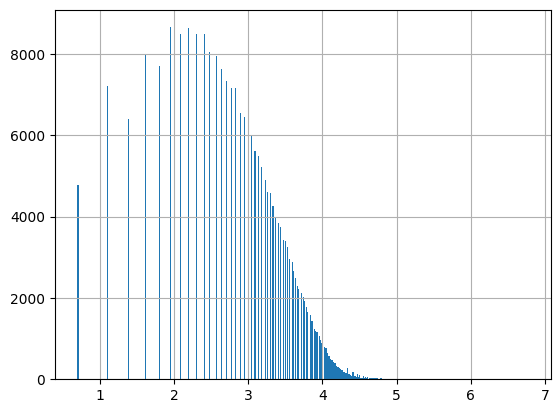

In [113]:
# np.log1p(visits_df_past["visitors"]).hist(bins=400)

__INFERENCE__

This histogram is heavily right skewe.

most days have very low visitors.

Afew days have huge counts.

__Median number of visitors in a month,day,year__

In [122]:
visits_df_past.head(1)

,id,visitors,visit_datetime,store_type,store_id,dataset,day_of_week,holiday_flg,weekend_holiday,work_off,yesterday_isholiday,tomarrow_isholiday
0,air_ba937bf13d40fb24_2016-01-13,25,2016-01-13,air,air_ba937bf13d40fb24,past,Wednesday,0,0,0,0,0


In [198]:
visits = pd.DataFrame()
visits["d_of_w"] = visits_df_past["day_of_week"]
visits["d_m"] = visits_df_past["visit_datetime"].dt.month.map({1:'jan',2:"feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})
visits["visitors"]=visits_df_past["visitors"]
vis_day=visits.groupby("d_of_w")["visitors"].agg(["median"]).reset_index()
vis_week=visits.groupby("d_m")["visitors"].agg(["median"]).reset_index()
vis_week

,d_m,median
0,Apr,18.0
1,Aug,16.0
2,Dec,19.0
3,Jul,17.0
4,Jun,17.0
5,Mar,18.0
6,May,18.0
7,Nov,16.0
8,Oct,17.0
9,Sep,16.0


<Figure size 1200x1200 with 0 Axes>

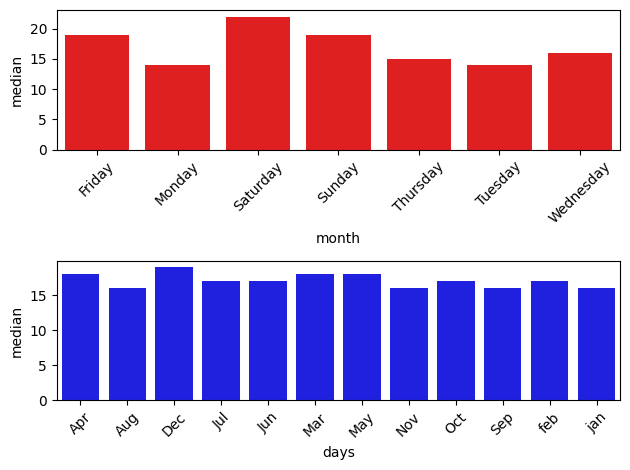

In [202]:
plt.figure(figsize=(12,12))
fig,ax = plt.subplots(2,1)
sns.barplot(x=vis_day["d_of_w"],y=vis_day["median"],ax=ax[0],color='red')
ax[0].set_xlabel("month")
ax[0].tick_params(axis='x',rotation=45)

sns.barplot(x=vis_week["d_m"],y=vis_week["median"],ax=ax[1],color='blue')
ax[1].set_xlabel("days")
ax[1].tick_params(axis='x',rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='day_of_week', ylabel='visitors'>

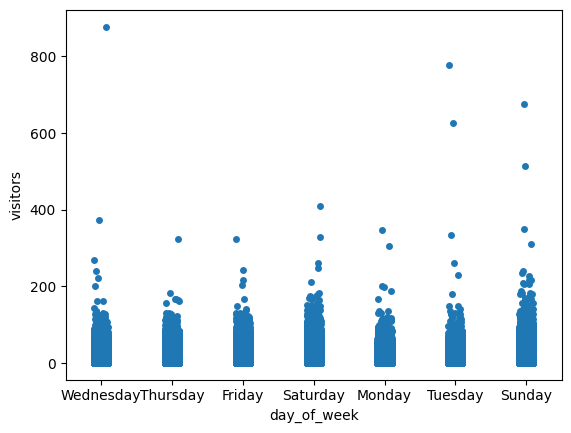

In [132]:
sns.stripplot(x=visits_df_past["day_of_week"],y=visits_df_past["visitors"])

__inference__

most of the visitors visits restaurent on saturday followed by sunday and friday(mostly weekend)

most visitors like to visit resturent in december month

the period March - May is also busy

In [203]:
store_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [222]:
store_reserve["visit_datetime"] = pd.to_datetime(store_reserve["visit_datetime"],format="%Y-%m-%d %H:%M:%S")
store_reserve["reserve_datetime"] = pd.to_datetime(store_reserve["reserve_datetime"],format="%Y-%m-%d %H:%M:%S")


store_reserve["vistDate"] = store_reserve["visit_datetime"].dt.date
store_reserve["reserveDate"] = store_reserve["reserve_datetime"].dt.date

store_reserve["reserveHours"] = store_reserve["reserve_datetime"].dt.hour
store_reserve["visitHours"] = store_reserve["visit_datetime"].dt.hour

store_reserve["reserve_ahead"]=store_reserve["vistDate"]-store_reserve["reserveDate"]
store_reserve["hours_ahead"]= store_reserve["visitHours"]-store_reserve["reserveHours"]

store_reserve["days_ahead"] = store_reserve["visit_datetime"].dt.day - store_reserve["reserve_datetime"].dt.day

In [223]:
store_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,vistDate,reserveDate,reserveHours,visitHours,reserve_ahead,hours_ahead,days_ahead
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,16,19,0:00:00,3,0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,19,19,0:00:00,0,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,19,19,0:00:00,0,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,16,20,0:00:00,4,0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,1,20,0:00:00,19,0


In [240]:
pt1_reserve=store_reserve.groupby("reserveDate")["reserve_visitors"].agg(["sum"])
pt1_reserve

,sum
reserveDate,
2016-01-01,147
2016-01-02,321
2016-01-03,246
2016-01-04,650
2016-01-05,687
...,...
2017-04-18,2696
2017-04-19,2302
2017-04-20,2421


Text(0, 0.5, 'visitor')

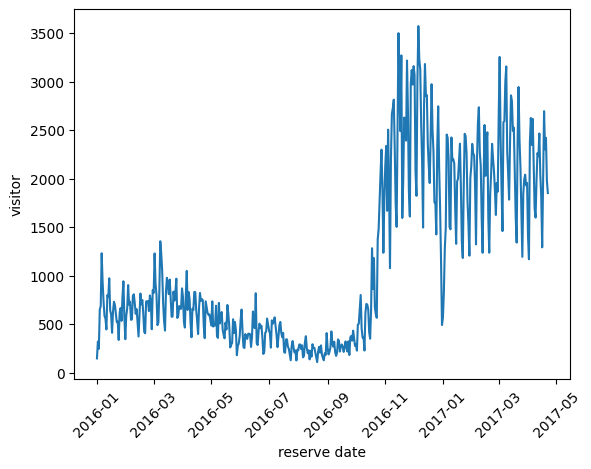

In [237]:
plt.plot(pt1_reserve.index,pt1["sum"])
plt.tick_params(axis='x',rotation=45)
plt.xlabel("reserve date")
plt.ylabel("visitor")

,count,nunique
visit_datetime,,
2016-01-01,46,46
2016-01-02,62,62
2016-01-03,80,80
2016-01-04,157,157
2016-01-05,230,230
...,...,...
2017-04-18,722,722
2017-04-19,734,734
2017-04-20,749,749


In [248]:
pt1_reserve.merge(store_reserve.groupby("reserveDate")["air_store_id"].agg(['count','nunique']),right_index=True,left_index=True)

,sum,count,nunique
reserveDate,,,
2016-01-01,147,42,22
2016-01-02,321,68,36
2016-01-03,246,49,41
2016-01-04,650,114,61
2016-01-05,687,152,73
...,...,...,...
2017-04-18,2696,600,164
2017-04-19,2302,531,183
2017-04-20,2421,559,176
